### Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, confusion_matrix
from sklearn.cluster import KMeans 
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import LinearSVR

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Task 4: To explore Business Analytics 

Perform ‘Exploratory Data Analysis’ on the provided dataset ‘SampleSuperstore’. You are the business owner of the retail firm and want to see how your company is performing. You are interested in finding out the weak areas where you can work to make more profit. What all business problems you can derive by looking into the data?

In [2]:
data = pd.read_csv('SampleSuperstore.csv')

In [3]:
data.head()

,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit
0,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.9600,2,0.00,41.9136
1,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,731.9400,3,0.00,219.5820
2,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.6200,2,0.00,6.8714
3,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,957.5775,5,0.45,-383.0310
4,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,22.3680,2,0.20,2.5164


### Profits by City

Text(0, 0.5, 'Net profit')

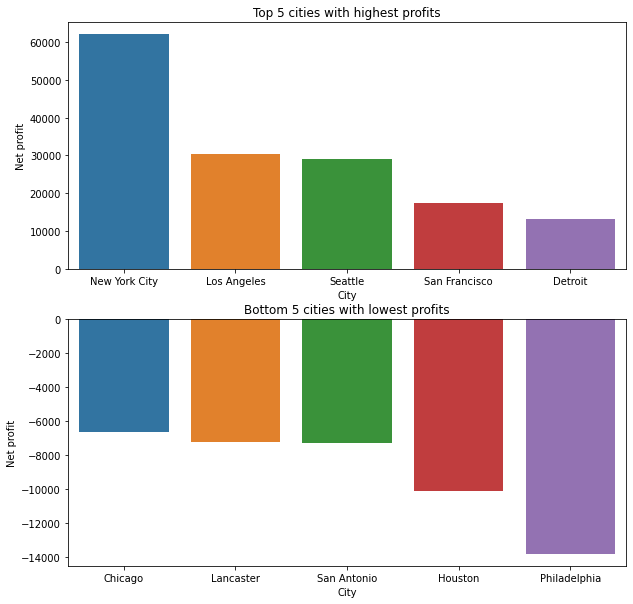

In [4]:
profit_df = data[['City','Profit']]
profit_df = profit_df.groupby('City').sum()
profit_df = profit_df.sort_values(by='Profit',ascending=False)
top_5_cities = profit_df[:5]
bottom_5_cities = profit_df[-5:]
plt.rcParams['figure.figsize'] = (10,10)
plt.subplot(2,1,1)
plt.title('Top 5 cities with highest profits')
sns.barplot(data = top_5_cities,x = top_5_cities.index,y='Profit')
plt.xlabel('City')
plt.ylabel('Net profit')
plt.subplot(2,1,2)
plt.title('Bottom 5 cities with lowest profits')
sns.barplot(data = bottom_5_cities,x = bottom_5_cities.index,y='Profit')
plt.xlabel('City')
plt.ylabel('Net profit')

### Profits by Category of products

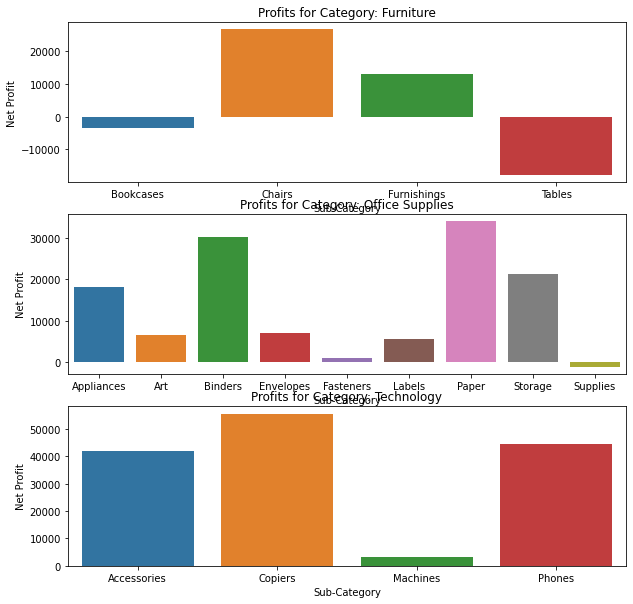

In [5]:
product_df = data[['Category','Sub-Category','Profit']]
count=1
for category,df in product_df.groupby('Category'):
    df = df.groupby('Sub-Category').sum()
    plt.subplot(3,1,count)
    plt.rcParams['figure.figsize'] = (20,20)
    plt.title('Profits for Category: '+category)
    sns.barplot(data=df,x=df.index,y='Profit')
    plt.ylabel('Net Profit')
    count+=1

### Region-wise, Segment-wise and Shipping-mode-wise Profits 

Text(0.5, 1.0, 'Percentage of Superstore Net-Profit observed \nShipping-mode-wise')

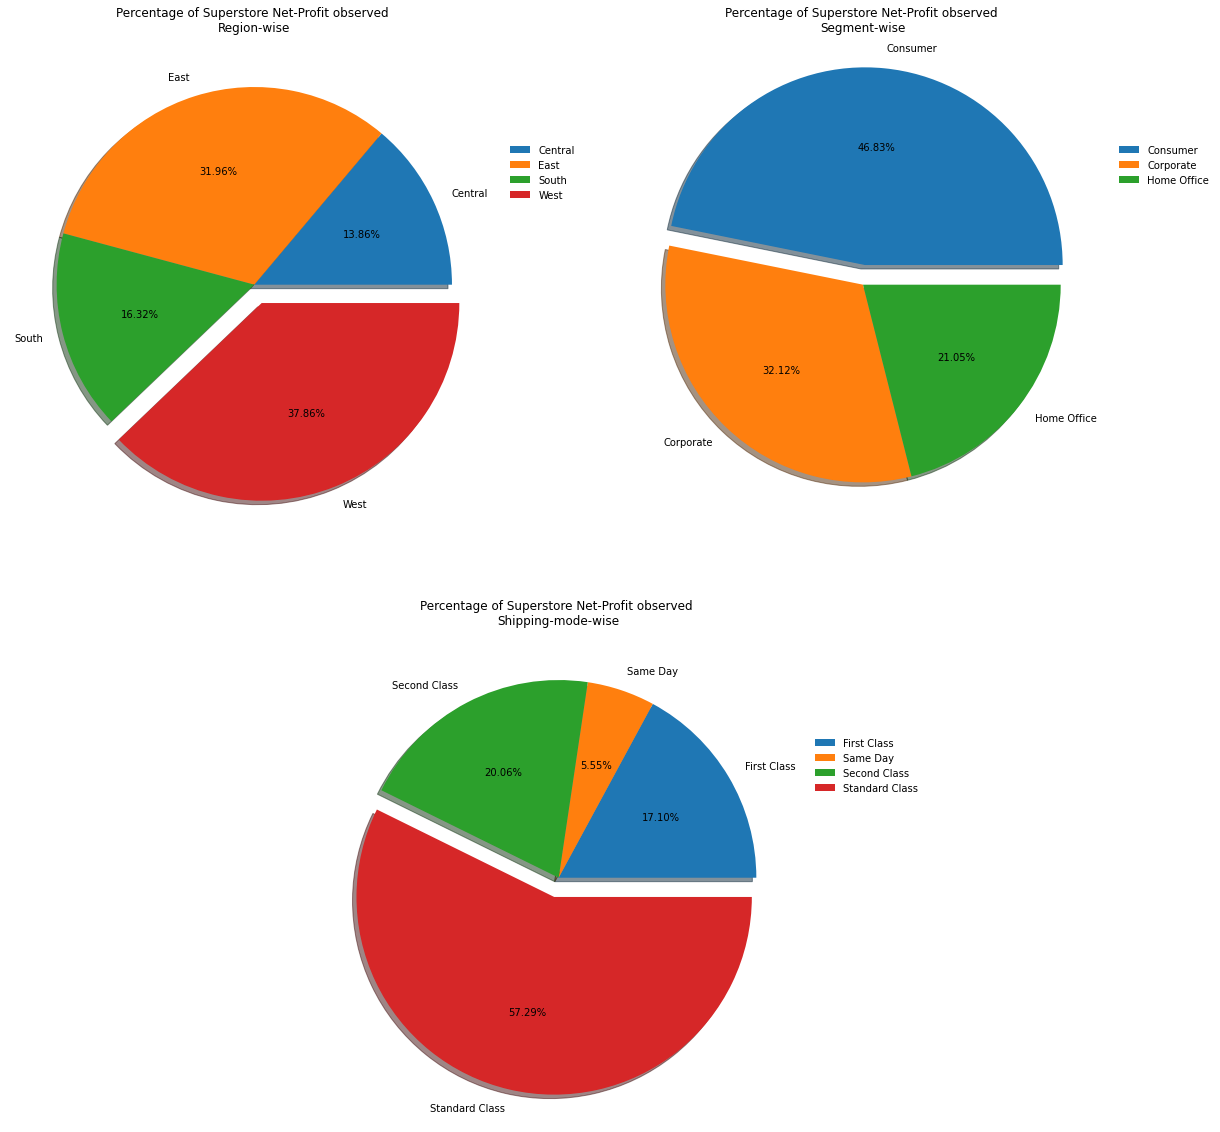

In [6]:
region_df = data[['Region','Profit']]
region_df = region_df.groupby('Region').sum()
plt.rcParams['figure.figsize']=(20,20)
plt.subplot(2,2,1)
plt.pie(region_df['Profit'],shadow=True,explode=[0,0,0,0.1],labels=region_df.index,autopct='%1.2f%%')
plt.legend(frameon=False, bbox_to_anchor=(1,0.8))
plt.title('Percentage of Superstore Net-Profit observed \nRegion-wise')
print()
segment_df = data[['Segment','Profit']]
segment_df = segment_df.groupby('Segment').sum()
plt.subplot(2,2,2)
plt.pie(segment_df['Profit'],shadow=True,explode=[0.1,0,0],labels=segment_df.index,autopct='%1.2f%%')
plt.legend(frameon=False, bbox_to_anchor=(1,0.8))
plt.title('Percentage of Superstore Net-Profit observed \nSegment-wise')
shipping_df = data[['Ship Mode','Profit']]
shipping_df = shipping_df.groupby('Ship Mode').sum() 
plt.subplot(2,2,(3,4))
plt.pie(shipping_df['Profit'],shadow=True,explode=[0,0,0,0.1],labels=shipping_df.index,autopct='%1.2f%%')
plt.legend(frameon=False, bbox_to_anchor=(1,0.8))
plt.title('Percentage of Superstore Net-Profit observed \nShipping-mode-wise')


### Finding relation between Sales, Quantity, Profit and Discount

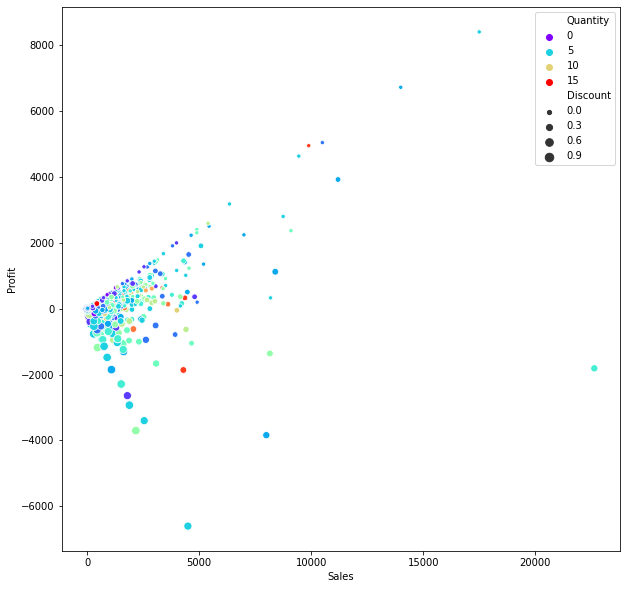

In [7]:
df = data[['Sales','Quantity','Discount','Profit']]
plt.rcParams['figure.figsize'] = (10,10)
sns.scatterplot(data = df,x='Sales',y='Profit',hue='Quantity',size='Discount',palette='rainbow')

### Segment vs State

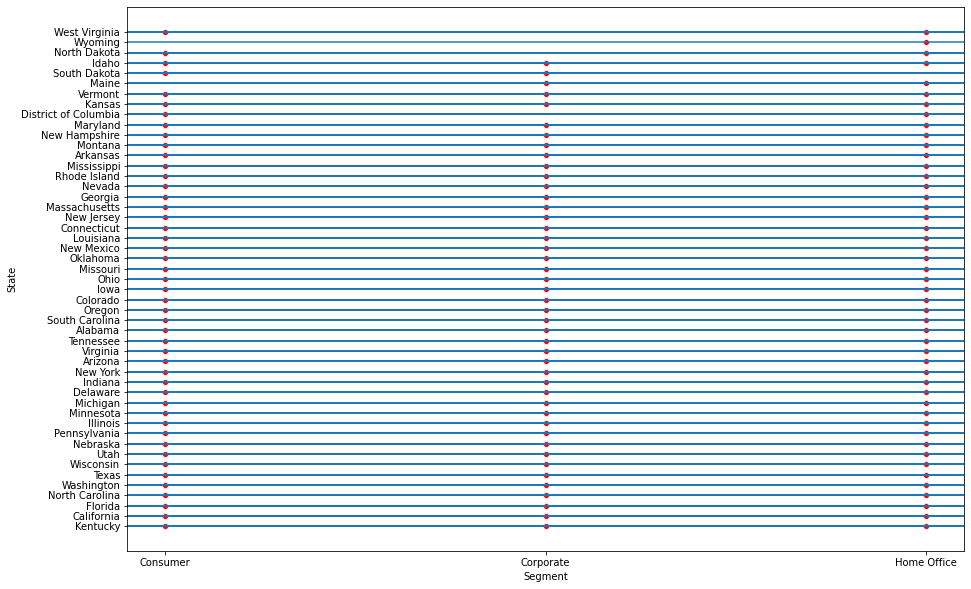

In [8]:
plt.rcParams['figure.figsize'] = (15,10)
df = data[['Segment','State']]
sns.scatterplot(data = df,x = 'Segment',y = 'State',color='red')
for i in list(df['State']):
    plt.axhline(y=i)

It appears that most of the state have all the three segments(Consumer, Corporate, Home Office) for their operations except:
* District of Columbia, North Dakota and West Virginia which doesn't have any Corporate Segment. 
* Wyoming, which doesn't have either Consumer or Corporate Segment.
* Maine, which doesn't have any Consumer Segment.





### Region vs Category

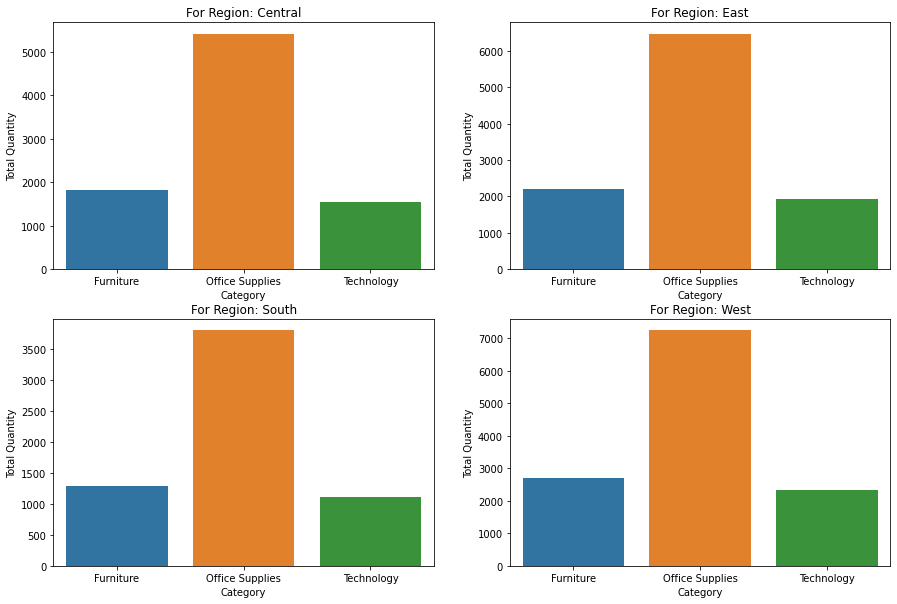

In [9]:
df = data[['Region','Category','Quantity']]
count = 1
for region, df in df.groupby('Region'):
    df = df.groupby('Category').sum()
    plt.subplot(2,2,count)
    plt.title('For Region: '+region)
    sns.barplot(data = df,x = df.index ,y = 'Quantity')
    plt.ylabel('Total Quantity')
    count+=1

It appears that office supplies are sold maximum in every region and technology based products are sold the lowest.

### Profit based Regression Modeling

### Exploring presence of outliers

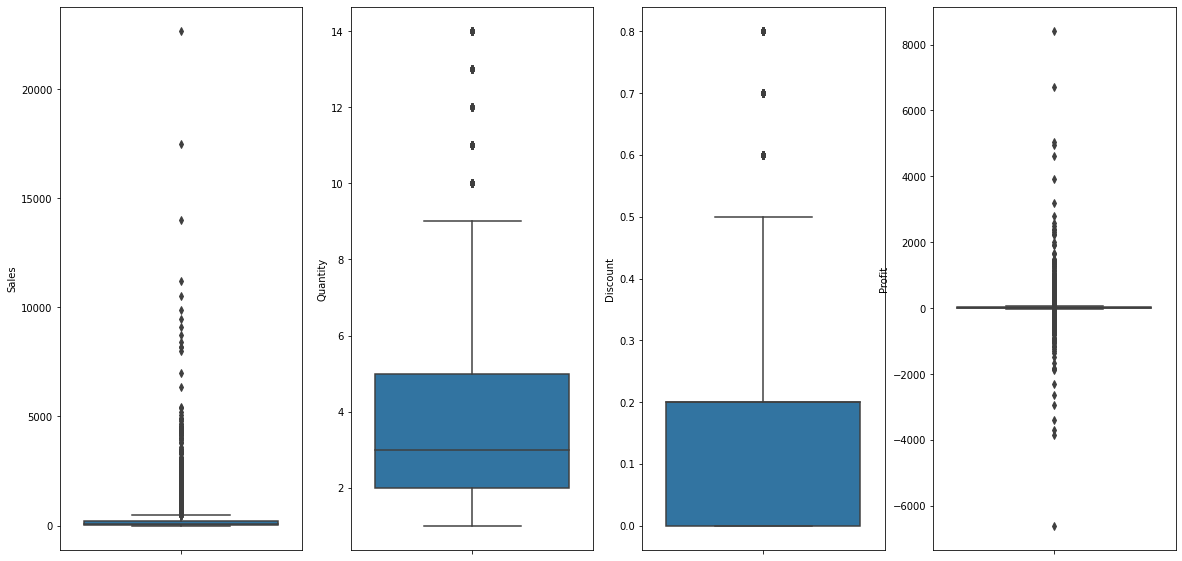

In [10]:
features = ['Sales','Quantity','Discount','Profit']
df = data[features]
count=1
plt.rcParams['figure.figsize'] = (20,10)
for feature in features:
    plt.subplot(1,4,count)
    sns.boxplot(df[feature],orient='v')
    count+=1

Altough, there are lot of outliers in Profit, Sales, Quantity and Discount columns, many of them are important for our predictions, the central value of the profit lies at 0, which is very few, most of them are either highly positive profits or highly negative losses. So, we won't perform outlier removal.

###Heatmap to estimate correlation with Profit feature

We will not be using one-hot encoding since there are too many categorical features, neither label encoding because it's misleading as while assigning 1,2,3... one category will be considered of greater importance than other, which can lead to false sense of positive correlation existing with the profit. So, this leads to other form of encoding called bin encoding where categories of any categorical features are replaced by their respective probability of occurence in the dataset.

In [11]:
def bin_encoding(df,feature):
  encode_dict = dict.fromkeys(set(df[feature]),0)
  for key in encode_dict:
    encode_dict[key] = len(df[df[feature]==key])/len(df)
  return df[feature].apply(lambda x:encode_dict[x])
new_data = data.copy()
for col in list(new_data.columns):
  if data[col].dtype=='O' or col=='Postal Code':
      new_data[col] = bin_encoding(new_data,col)

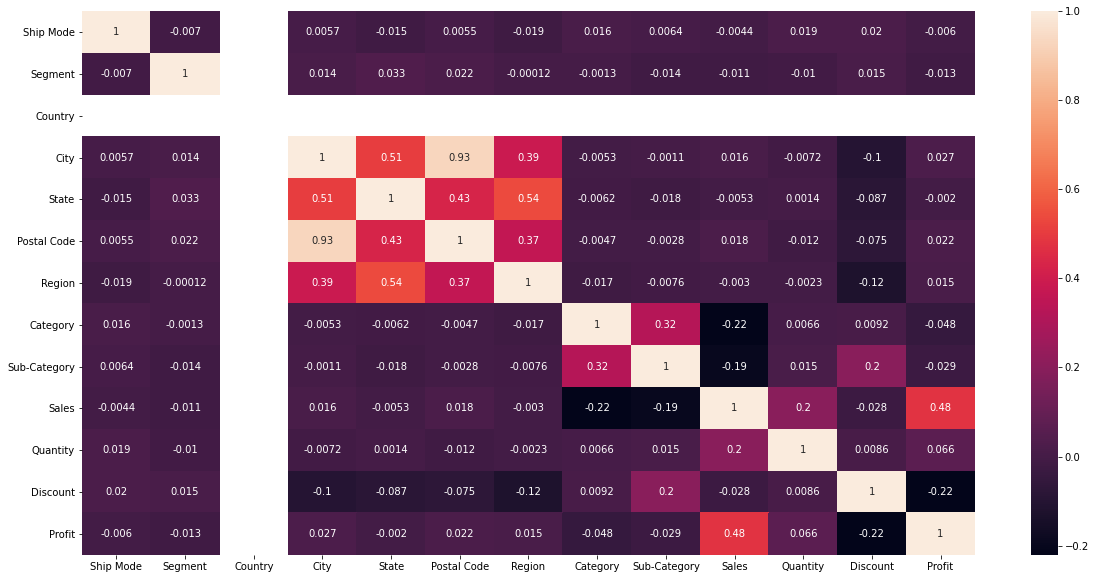

In [12]:
plt.rcParams['figure.figsize'] = (20,10)
sns.heatmap(new_data.corr(),annot=True)

For predicting profit, all the features except State, Ship Mode and Country bear significant correlation with it.  

In [13]:
selected_features = list(set(new_data.columns) - {'Profit','State','Ship Mode','Country'})

### Checking for null values

In [14]:
new_data.isnull().sum()

Ship Mode       0
Segment         0
Country         0
City            0
State           0
Postal Code     0
Region          0
Category        0
Sub-Category    0
Sales           0
Quantity        0
Discount        0
Profit          0
dtype: int64

There are no null values, so we need not perform any form of missing values imputations.

In [15]:
Y = new_data['Profit']
X = new_data.loc[:,selected_features]

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)

In [17]:
print('train data shape {}, train label shape {}'.format(X_train.shape,Y_train.shape))
print('test data shape {}, test label shape {}'.format(X_test.shape,Y_test.shape))

train data shape (7995, 9), train label shape (7995,)
test data shape (1999, 9), test label shape (1999,)


### Using Random Forest

In [18]:
rfr = RandomForestRegressor(n_estimators=100,random_state=0,max_features=len(selected_features))
rfr.fit(X_train,Y_train)
Y_test_pred = rfr.predict(X_test)
Y_train_pred = rfr.predict(X_train) 
print('R2 score for train data:',r2_score(Y_train,Y_train_pred))
print('R2 score for test data:',r2_score(Y_test,Y_test_pred))

R2 score for train data: 0.9585179745802009
R2 score for test data: 0.8021618202900425


### Using AdaBoost Boosting Algorithm for Random Forest

In [19]:
ad = AdaBoostRegressor(rfr,learning_rate=0.1,random_state=0,n_estimators=100)
ad.fit(X_train,Y_train)
Y_test_pred = ad.predict(X_test)
Y_train_pred = ad.predict(X_train) 
print('R2 score for train data:',r2_score(Y_train,Y_train_pred))
print('R2 score for test data:',r2_score(Y_test,Y_test_pred))

R2 score for train data: 0.9995138370145594
R2 score for test data: 0.8652001023958469


### Using Linear Regression Model

In [20]:
X_poly_train = PolynomialFeatures(3).fit_transform(X_train)
X_poly_test = PolynomialFeatures(3).fit_transform(X_test)
lin_reg = LinearRegression()
lin_reg.fit(X_poly_train,Y_train)
Y_test_pred = lin_reg.predict(X_poly_test)
Y_train_pred = lin_reg.predict(X_poly_train)
print('R2 score for train data:',r2_score(Y_train,Y_train_pred))
print('R2 score for test data:',r2_score(Y_test,Y_test_pred))

R2 score for train data: 0.9489506093011572
R2 score for test data: 0.9111639266544113


It appears that Linear Regression Model gives better accuracy than AdaBoost and Random Forest Models.